In [1]:
from dimension_encoding.utils import load_singletrial_data
from dimension_encoding.shapemodel import load_shapecomps, make_shape_model, find_embedding_fmritrials
from os.path import join as pjoin, pardir
import pandas as pd
import numpy as np
from dimension_encoding.utils import load_clip66_preds
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
bidsroot = '/LOCAL/ocontier/thingsmri/bids'
sub = '01'
respdata, voxdata, stimdata = load_singletrial_data(bidsroot, sub, drop_voxelid=True)
y = respdata.T

loading responses
dropping "voxel_id" column from response data
loading meta data


In [3]:
shapecomps, shapecomp_fnames = load_shapecomps()

In [6]:
shapecomp_model_info = make_shape_model(stimdata, shapecomps, shapecomp_fnames)
X_shape = shapecomp_model_info['design_matrix']
val_inds = shapecomp_model_info['val_trial_inds']

In [14]:
# load the behavior model
dim66dir = pjoin(pardir, 'data', '66d')
stimdata_val = stimdata.iloc[val_inds]
trials = find_embedding_fmritrials(stimdata_val, dim66dir)
X_dims = trials.drop(columns=['imagename'], inplace=False).to_numpy()

find dimensions for fMRI stimuli: 100%|██████████| 8967/8967 [00:33<00:00, 264.45it/s]


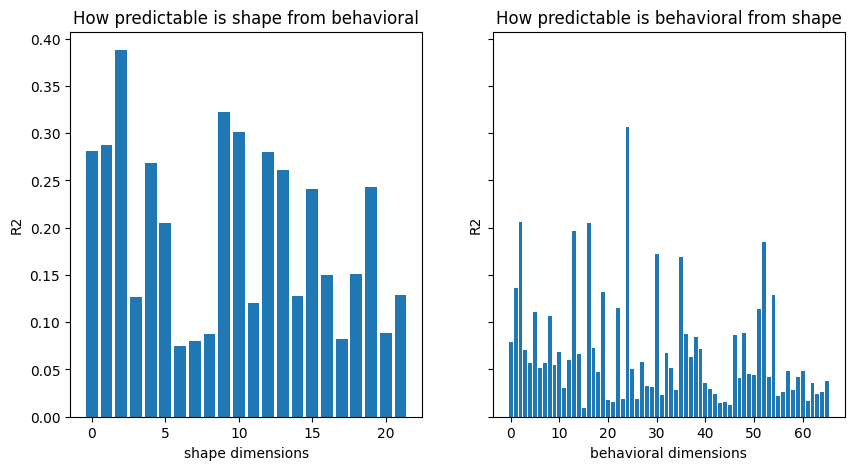

In [21]:
# How correlated are the two models?
lr = LinearRegression(n_jobs=10)
lr.fit(X_dims, X_shape)
scores_shape = r2_score(X_shape, lr.predict(X_dims), multioutput='raw_values')
lr.fit(X_shape, X_dims)
scores_dims = r2_score(X_dims, lr.predict(X_shape), multioutput='raw_values')

modelnames = ['shape', 'behavioral']
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
for i, (a, data, dataname) in enumerate(zip(axs, [scores_shape, scores_dims], modelnames)):
    a.bar(range(len(data)), data)
    other_i = i-1
    a.set_title(f'How predictable is {dataname} from {modelnames[other_i]}')
    a.set_xlabel(f"{dataname} dimensions")
    a.set_ylabel('R2')
plt.show()

# Based on Jessica Loke's segmentations

In [4]:
val_fmri_inds, X_shape = make_shape_model(stimdata, shapecomps, shapecomp_fnames)

In [5]:
print(f"{respdata.shape[1] - val_fmri_inds.shape[0]} fMRI trials without shape parameters")

9 fMRI trials without shape parameters


In [29]:
# filter fMRI trials based on shape model
y = respdata.to_numpy().T[val_fmri_inds]
stimdata_val = stimdata.iloc[val_fmri_inds]

In [30]:
# load the behavior model
dim66dir = pjoin(pardir, 'data', '66d')
embedding, filenames, labels = load_clip66_preds(dim66dir)
trials = find_embedding_fmritrials(stimdata_val, dim66dir)
X_dims = trials.drop(columns=['imagename'], inplace=False).to_numpy()

find dimensions for fMRI stimuli: 100%|██████████| 9831/9831 [00:22<00:00, 441.08it/s]


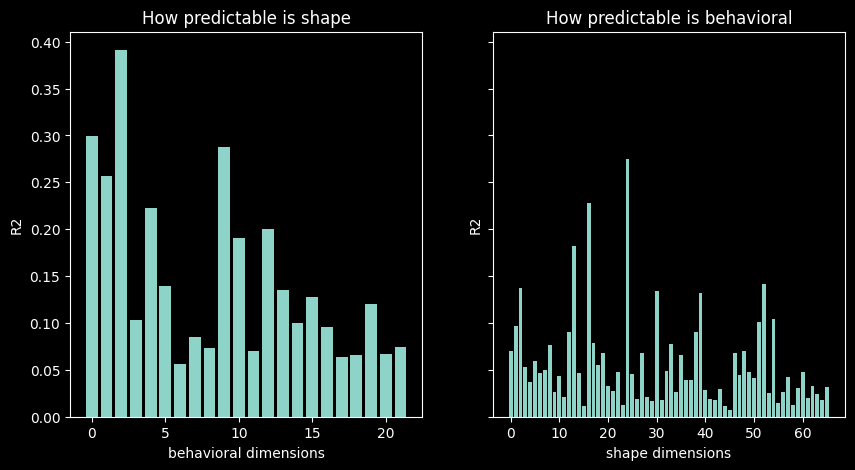

In [34]:
# How correlated are the two models?
lr = LinearRegression(n_jobs=10)
lr.fit(X_dims, X_shape)
scores_shape = r2_score(X_shape, lr.predict(X_dims), multioutput='raw_values')
lr.fit(X_shape, X_dims)
scores_dims = r2_score(X_dims, lr.predict(X_shape), multioutput='raw_values')

modelnames = ['shape', 'behavioral']
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
for i, (a, data, dataname) in enumerate(zip(axs, [scores_shape, scores_dims], modelnames)):
    a.bar(range(len(data)), data)
    other_i = i-1
    a.set_title(f'How predictable is {dataname}')
    a.set_xlabel(f"{modelnames[other_i]} dimensions")
    a.set_ylabel('R2')
plt.show()